<a href="https://colab.research.google.com/github/ShabnaIlmi/Data-Science-Group-Project/blob/main/DSGP_UserData_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Classification Report:
               precision    recall  f1-score   support

   High Risk       0.00      0.00      0.00         8
    Low Risk       0.99      0.98      0.98       224
 Medium Risk       0.92      1.00      0.96        89
     No Risk       0.43      0.50      0.46         6

    accuracy                           0.95       327
   macro avg       0.58      0.62      0.60       327
weighted avg       0.93      0.95      0.94       327

Accuracy: 0.95


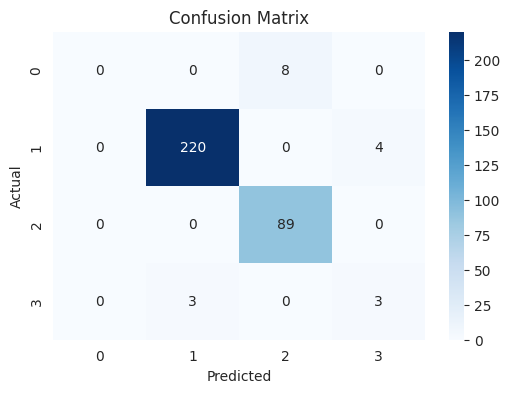

Predicted Risk Level for Sinopec: Medium Risk


In [27]:
# Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# 1 Load Dataset
file_path = "/content/drive/MyDrive/DSGP_User/Pre Processed data/Stock-report_with_risk.xlsx"
data = pd.read_excel(file_path)

# 2 Strip column names to avoid hidden spaces
data.columns = data.columns.str.strip()

# 3 Define Target Variable
target_col = "Risk Level"

# 4 Identify categorical and numerical columns
categorical_cols = ['Customer name', 'Product code', 'Invoice No', 'UOM', 'Warehouse']
numerical_cols = ['Issued Qty', 'Transaction Date']

# 5 Convert Transaction Date to numeric (days since epoch)
data['Transaction Date'] = pd.to_datetime(data['Transaction Date'], errors='coerce')
data['Transaction Date'] = data['Transaction Date'].astype(int) / 10**9

# 6 Handle categorical variables using Label Encoding
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    label_encoders[col] = le  # Store the encoder for later use in prediction

# 7 Fill missing values in numerical columns
data[numerical_cols] = data[numerical_cols].fillna(0)

# 8 Define Features (X) and Target (y)
X = data.drop(columns=[target_col])
y = data[target_col]

# 9 Train-Test Split (80-20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 10 Feature Scaling
scaler = StandardScaler()
X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])

# 11 Train Random Forest Model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# 12 Model Evaluation
y_pred = rf_model.predict(X_test)
print("Classification Report:\n", classification_report(y_test, y_pred))
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")

# 13 Confusion Matrix Visualization
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# 14 Prediction Function
def predict_risk_level(customer_name, issued_qty, transaction_date, product_code):
    """
    Predicts the risk level for a given customer based on provided data.
    """
    # Create DataFrame for input data
    input_data = pd.DataFrame({
        'Customer name': [customer_name],
        'Issued Qty': [issued_qty],
        'Transaction Date': [transaction_date],
        'Product code': [product_code]
    })

    # Strip column names
    input_data.columns = input_data.columns.str.strip()

    # Convert Transaction Date to numeric
    input_data['Transaction Date'] = pd.to_datetime(input_data['Transaction Date'], errors='coerce')
    input_data['Transaction Date'] = input_data['Transaction Date'].astype(int) / 10**9

    # Encode categorical variables using trained label encoders
    for col in categorical_cols:
        if col in input_data.columns:
            if input_data[col][0] in label_encoders[col].classes_:
                input_data[col] = label_encoders[col].transform(input_data[col])
            else:
                print(f"Warning: Unseen category '{input_data[col][0]}' in '{col}'. Assigning default category 0.")
                input_data[col] = 0  # Assign unseen categories a default value

    # Fill missing numerical values
    input_data[numerical_cols] = input_data[numerical_cols].fillna(0)

    # Ensure all expected columns are present, adding missing ones as 0
    for col in X_train.columns:
        if col not in input_data.columns:
            input_data[col] = 0  # Fill missing columns with 0

    # Ensure correct feature order
    input_data = input_data[X_train.columns]

    # Scale numerical features
    input_data[numerical_cols] = scaler.transform(input_data[numerical_cols])

    # Make the prediction
    predicted_risk = rf_model.predict(input_data)[0]

    return predicted_risk


# 15 Example Usage (Pre-defined Input)
customer_name = "Sinopec"  # Replace with  customer name
issued_qty = 2001  #  quantity
transaction_date = "2025-02-01"  # Transaction date
product_code = "H2O2-50%-IG-ICL-BANGLADESH"  # Replace with product code

# Predict risk level
predicted_risk = predict_risk_level(customer_name, issued_qty, transaction_date, product_code)

# Print the result
print(f"Predicted Risk Level for {customer_name}: {predicted_risk}")

